/home/jovyan/mursst-icechunk-updater/.venv/lib/python3.12/site-packages/numcodecs/zarr3.py:145: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 8TB
Dimensions:           (time: 436, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 3kB 2024-06-02T09:00:00 ... 2025-...
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
Data variables:
    mask              (time, lat, lon) float32 1TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

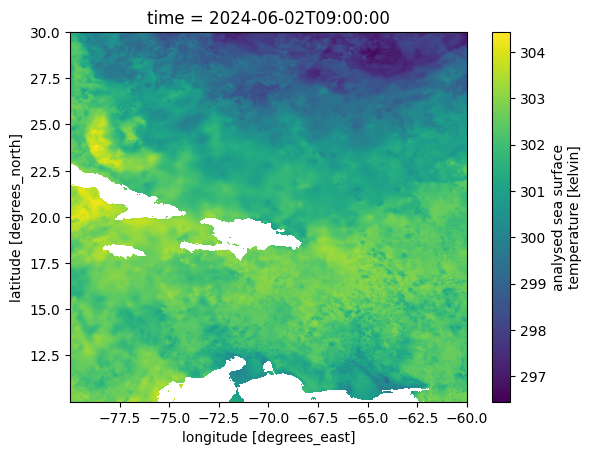

In [10]:
import icechunk as ic
from icechunk.credentials import S3StaticCredentials
from datetime import datetime
from urllib.parse import urlparse
import earthaccess
import xarray as xr

store_url = "s3://nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-virtual-v2-p2"
store_url_parsed = urlparse(store_url)

storage = ic.s3_storage(
    bucket = store_url_parsed.netloc,
    prefix = store_url_parsed.path,
    from_env=True,
)

def get_icechunk_creds(daac: str = None) -> S3StaticCredentials:
    if daac is None:
        daac = "PODAAC"  # TODO: Might want to change this for a more general version
        # https://github.com/nsidc/earthaccess/discussions/1051 could help here.
    # assumes that username and password are available in the environment
    # TODO: accomodate rc file?
    auth = earthaccess.login(strategy="environment")
    if not auth.authenticated:
        raise PermissionError("Could not authenticate using environment variables")
    creds = auth.get_s3_credentials(daac=daac)
    return S3StaticCredentials(
        access_key_id=creds["accessKeyId"],
        secret_access_key=creds["secretAccessKey"],
        expires_after=datetime.fromisoformat(creds["expiration"]),
        session_token=creds["sessionToken"],
    )



# TODO: Is there a way to avoid double opening? Maybe not super important
repo = ic.Repository.open(
    storage=storage,
)
# see if reopening works
repo = ic.Repository.open(
    storage=storage,
    authorize_virtual_chunk_access = ic.containers_credentials(
        {
            k: ic.s3_refreshable_credentials(
                    get_credentials=get_icechunk_creds
                ) for k in repo.config.virtual_chunk_containers.keys()
        }
    )
)

session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, zarr_format=3, consolidated=False)
ds['analysed_sst'].isel(time=0, lon=slice(10000, 12000), lat=slice(10000, 12000)).plot()

In [18]:
repo.list_branches()

{'add_time_2025-08-14T23:09:08.975729+00:00',
 'add_time_2025-08-15T21:12:12.028418+00:00',
 'main'}

# MRE for getting the storage config

In [ ]:
add_time_2025-08-14T23:09:08.975729+00:00 

## Ummm why is that store not visible with fsspec?

In [2]:
import fsspec

In [3]:
store_url

's3://nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-virtual-v2-p2'

In [4]:
fs = fsspec.filesystem('s3')
fs.ls("nasa-eodc-public/icechunk")

['nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-virtual-v1',
 'nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-virtual-v1-p2',
 'nasa-eodc-public/icechunk/test']

In [12]:
import obstore

In [13]:
from obstore.store import from_url

store = obstore.store.from_url(
    "s3://nasa-eodc-public/icechunk",
    skip_signature=True
)

In [14]:
store.list_with_delimiter("MUR-JPL-L4-GLOB-v4.1-virtual-v2-p2")

{'common_prefixes': [], 'objects': []}